# Lab. 2 - Análise Exploratória e Aprendizado Não-Supervisionado
### CMC-13 Introdução a Ciência de Dados

### Alunos:
- **João Pedro Couto Vieira**
- **Pedro de Oliveira Ramos**
- **Rafael Duarte Rocha**
- **Vinícius Ribeiro Rodrigues Camelo**

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans

df = pd.read_csv('./dataset_lab2.csv')

## 1. Preparação dos Dados
Primeiramente, analisa-se o aspecto geral do dataset, visualizando todas as colunas e os tipos de dados presentes.

In [6]:
df.head()

,id,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw
0,0,8.078,6.68,7.201,4.88,4.181,3.70,5.50,4.03,3.870,3.84
1,1,8.891,6.63,8.053,5.59,4.704,4.30,80.22,4.51,4.150,4.01
2,2,7.997,6.37,6.926,5.28,4.307,3.90,75.35,4.04,3.831,3.34
3,3,7.765,5.70,6.576,4.77,4.004,3.52,69.17,3.40,3.578,3.41
4,4,6.280,4.84,5.209,3.73,3.395,2.72,56.27,2.96,3.188,3.13


Vamos avaliar a presença de valores nulos e a distribuição dos dados em cada coluna.

In [7]:
df.nunique()

id       420
huml     407
humw     321
ulnal    398
ulnaw    308
feml     402
femw     290
tibl     405
tibw     288
tarl     409
tarw     279
dtype: int64

Vemos que algumas features não apresentam todos os valores, o que pode se tornar um problema para a análise. 


In [8]:
# Retirando valores ausentes
df.dropna(inplace=True)
df.describe()

,id,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw
count,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000
mean,207.987893,6.487487,4.381235,6.919741,3.606538,3.682245,3.221768,64.615642,3.182324,3.930981,2.944891
std,121.199236,5.405608,2.861460,5.892949,2.190150,1.989936,2.021169,37.977929,2.084124,2.327270,2.194744
min,0.000000,0.985000,1.140000,1.409000,1.000000,1.183000,0.930000,5.500000,0.870000,0.777000,0.660000
25%,103.000000,2.536000,2.200000,2.816000,1.870000,2.135000,1.720000,36.350000,1.560000,2.305000,1.430000
50%,209.000000,4.418000,3.500000,4.371000,2.960000,3.109000,2.520000,51.880000,2.490000,3.174000,2.240000
75%,312.000000,9.049000,5.820000,9.752000,4.770000,4.709000,4.110000,82.870000,4.250000,5.044000,3.520000
max,419.000000,42.000000,17.840000,42.200000,12.000000,11.707000,11.640000,240.000000,11.030000,17.500000,14.090000


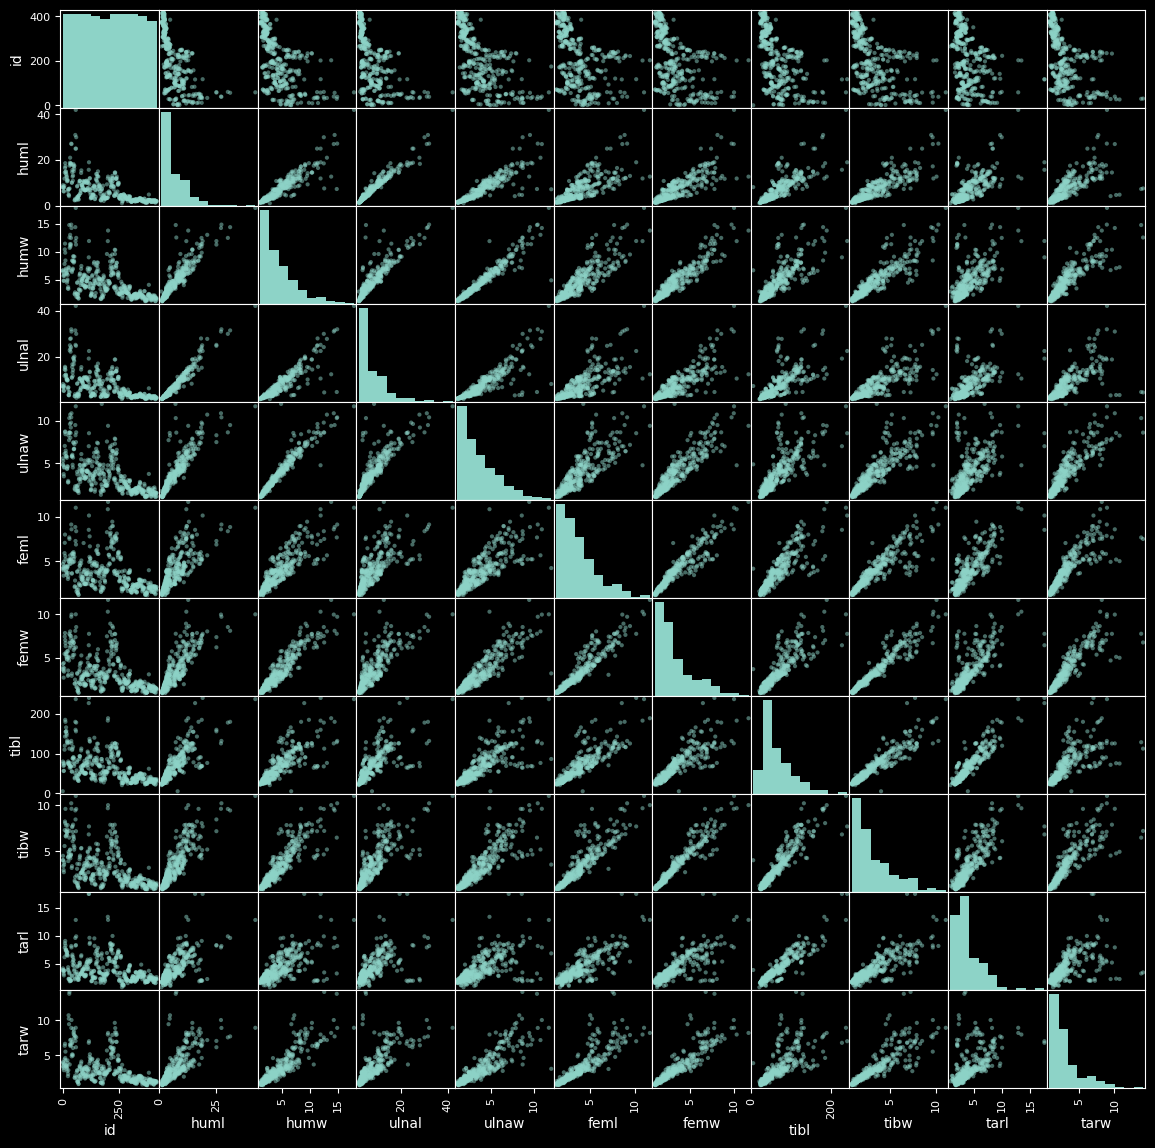

In [9]:
# Criando matriz de dispersão
scatter_matrix(df, alpha=0.5, figsize=(14, 14), diagonal='hist')
plt.show()

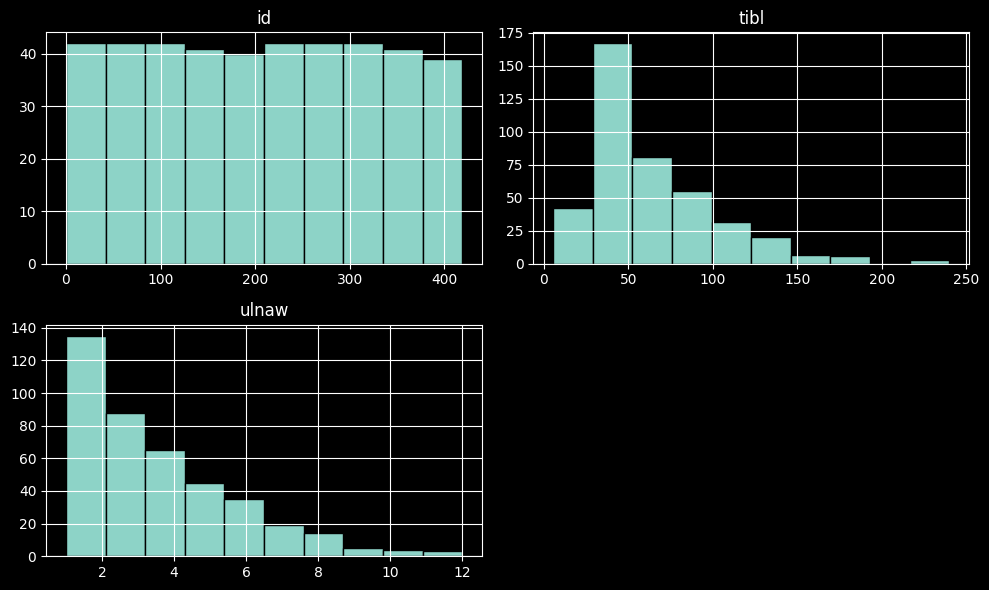

In [10]:
# Plotar histogramas para cada colun
df[['id','tibl','ulnaw']].hist(bins=10, figsize=(10, 6), edgecolor='black')

# Ajustar layout
plt.tight_layout()
plt.show()

In [11]:
# retirando a coluna ID
df.drop(columns=['id'],axis=1,inplace=True)

# Normalizando todas as colunas do df
df.max()
df_normalizado = df / df.max()
df_normalizado

,huml,humw,ulnal,ulnaw,feml,femw,tibl,tibw,tarl,tarw
0,0.192333,0.374439,0.170640,0.406667,0.357137,0.317869,0.022917,0.365367,0.221143,0.272534
1,0.211690,0.371637,0.190829,0.465833,0.401811,0.369416,0.334250,0.408885,0.237143,0.284599
2,0.190405,0.357063,0.164123,0.440000,0.367900,0.335052,0.313958,0.366274,0.218914,0.237048
3,0.184881,0.319507,0.155829,0.397500,0.342018,0.302405,0.288208,0.308250,0.204457,0.242016
4,0.149524,0.271300,0.123436,0.310833,0.289997,0.233677,0.234458,0.268359,0.182171,0.222143
...,...,...,...,...,...,...,...,...,...,...
415,0.042762,0.091368,0.045616,0.110833,0.156829,0.132302,0.130208,0.120580,0.125657,0.081618
416,0.045738,0.091928,0.049194,0.124167,0.164346,0.124570,0.138375,0.116047,0.134857,0.081618
417,0.044738,0.091368,0.046991,0.127500,0.179038,0.122852,0.143542,0.127833,0.130629,0.085877
418,0.048524,0.099776,0.053389,0.125000,0.182370,0.127148,0.150375,0.138713,0.148457,0.088006


In [12]:
# dataframe para armazenar os valores do kmeans
df_aprendizado = pd.DataFrame(df)

In [13]:
# Aplicando K-MEANS com 2 clusters
kmeans_2 = KMeans(n_clusters=2, random_state=50)
df_aprendizado['Cluster_2'] = kmeans_2.fit_predict(df)

# Aplicando K-MEANS com 3 clusters
kmeans_3 = KMeans(n_clusters=3, random_state=50)
df_aprendizado['Cluster_3'] = kmeans_3.fit_predict(df)

# Aplicando K-MEANS com 6 clusters
kmeans_6 = KMeans(n_clusters=6, random_state=50)
df_aprendizado['Cluster_6'] = kmeans_6.fit_predict(df)

# Aplicando K-MEANS com 9 clusters
kmeans_9 = KMeans(n_clusters=9, random_state=50)
df_aprendizado['Cluster_9'] = kmeans_9.fit_predict(df)



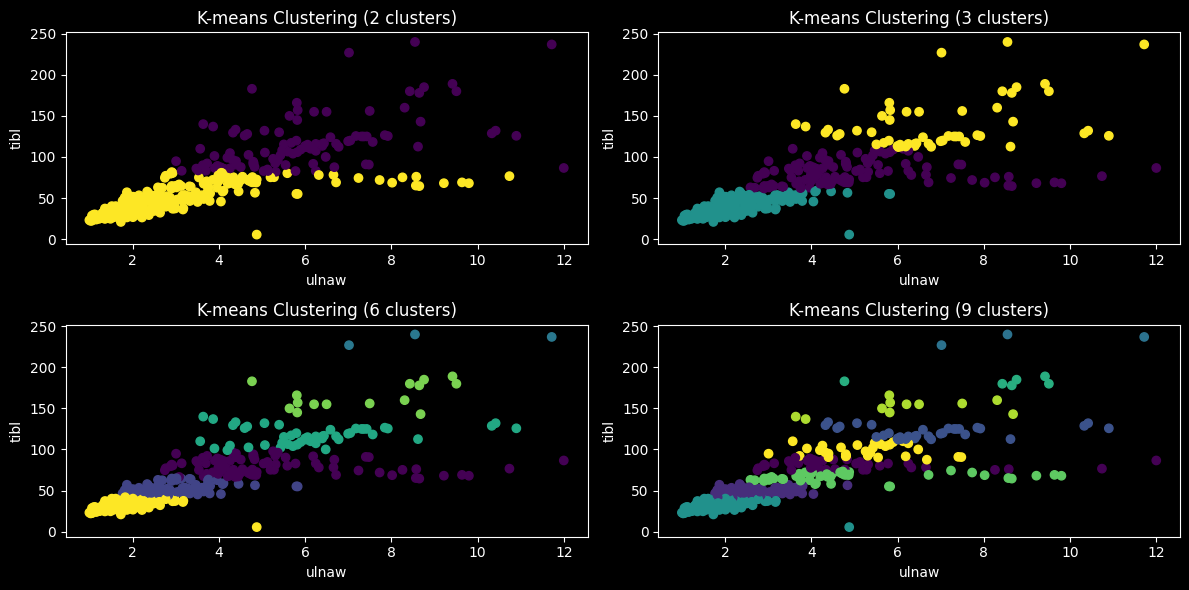

In [14]:
plt.figure(figsize=(12, 6))

# Plotting K-means with 2 clusters
plt.subplot(2, 2, 1)
plt.scatter(df_aprendizado['ulnaw'], df_aprendizado['tibl'], c=df_aprendizado['Cluster_2'], cmap='viridis')
plt.title('K-means Clustering (2 clusters)')
plt.xlabel('ulnaw')
plt.ylabel('tibl')

# Plotting K-means with 3 clusters
plt.subplot(2, 2, 2)
plt.scatter(df_aprendizado['ulnaw'], df_aprendizado['tibl'], c=df_aprendizado['Cluster_3'], cmap='viridis')
plt.title('K-means Clustering (3 clusters)')
plt.xlabel('ulnaw')
plt.ylabel('tibl')

# Plotting K-means with 6 clusters
plt.subplot(2, 2, 3)
plt.scatter(df_aprendizado['ulnaw'], df_aprendizado['tibl'], c=df_aprendizado['Cluster_6'], cmap='viridis')
plt.title('K-means Clustering (6 clusters)')
plt.xlabel('ulnaw')
plt.ylabel('tibl')

# Plotting K-means with 9 clusters
plt.subplot(2, 2, 4)
plt.scatter(df_aprendizado['ulnaw'], df_aprendizado['tibl'], c=df_aprendizado['Cluster_9'], cmap='viridis')
plt.title('K-means Clustering (9 clusters)')
plt.xlabel('ulnaw')
plt.ylabel('tibl')

plt.tight_layout()
plt.show()


Agora que fizemos algumas simulações, vamos fazer o Elbow Test para avaliar qual o melhor número de clusteres para o kmeans

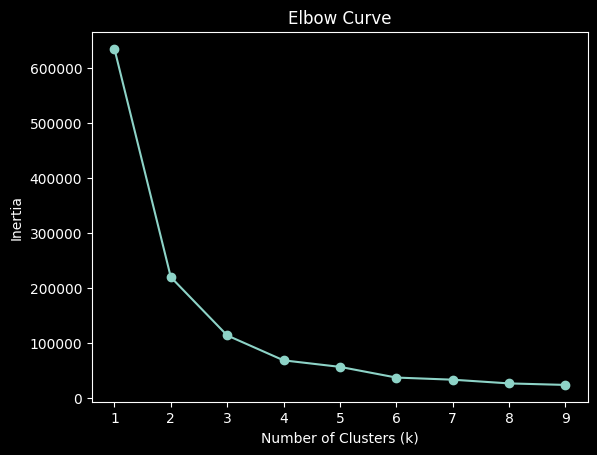

In [15]:
import numpy as np

# Define a range of k values
k_values = range(1, 10)

# Initialize an empty list to store the inertia values
inertia_values = []

# Perform KMeans clustering for each k value and calculate the inertia
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=50)
    kmeans.fit(df)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()
